##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lite를 사용한 초고해상도

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/examples/super_resolution/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/models/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/models/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/models/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

## 개요

저해상도 대상에서 고해상도(HR) 이미지를 복구하는 작업을 일반적으로 단일 이미지 초고해상도(SISR)라고 합니다.

여기에 사용된 모델은 ESRGAN([ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219))입니다. 그리고 TensorFlow Lite를 사용하여 사전 훈련된 모델에서 추론을 실행할 것입니다.

TFLite 모델은 TF Hub에서 호스팅되는 이 [구현](https://tfhub.dev/captain-pool/esrgan-tf2/1)에서 변환됩니다. 우리가 변환한 모델은 50x50 저해상도 이미지를 200x200 고해상도 이미지로 업샘플링했습니다(배율 계수=4). 다른 입력 크기나 배율을 원하면 원래 모델을 다시 변환하거나 다시 훈련해야 합니다.

## 설정

먼저 필요한 라이브러리를 설치합니다.

In [2]:
!pip install matplotlib tensorflow tensorflow-hub

종속성을 가져옵니다.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
print(tf.__version__)

2022-12-14 20:36:22.330988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:36:22.331130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:36:22.331142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


ESRGAN 모델을 다운로드하고 변환합니다.

In [4]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 50, 50, 3], dtype=tf.float32)])
def f(input):
  return concrete_func(input);

converter = tf.lite.TFLiteConverter.from_concrete_functions([f.get_concrete_function()], model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmppqw9pxod/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmppqw9pxod/assets


2022-12-14 20:36:42.232726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-14 20:36:42.232775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


테스트 이미지(곤충 머리)를 다운로드합니다.

In [5]:
test_img_path = tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

6432/6432 [==============================] - 0s 0us/step


## TensorFlow Lite를 사용하여 초고해상도 이미지 생성하기

In [6]:
lr = tf.io.read_file(test_img_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 결과 시각화하기

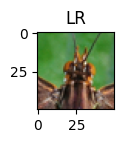

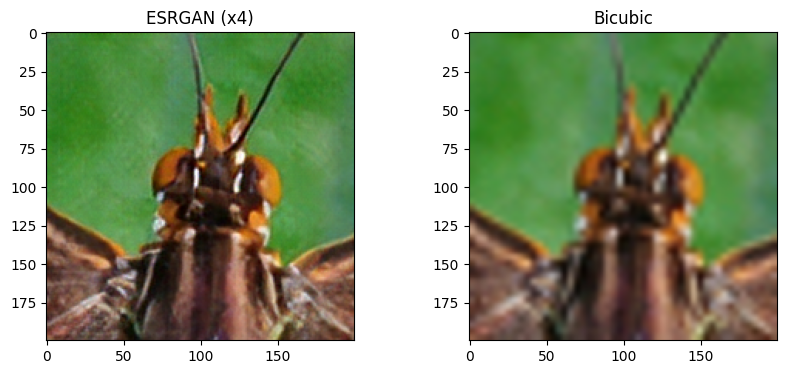

In [7]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

## 성능 벤치마크

성능 벤치 마크 수치는 [여기에 설명된](https://www.tensorflow.org/lite/performance/benchmarks) 도구를 사용하여 생성됩니다.

<table>
  <thead>
    <tr>
      <th>모델명</th>
      <th>모델 크기</th>
      <th>기기</th>
      <th>CPU</th>
      <th>GPU</th>
    </tr>
  </thead>
  <tr>
    <td rowspan="3">초고해상도(ESRGAN)</td>
    <td rowspan="3">       4.8 Mb</td>
    <td>Pixel 3</td>
    <td>586.8ms*</td>
      <td>128.6ms</td>
  </tr>
  <tr>
     <td>Pixel 4</td>
    <td>385.1ms*</td>
      <td>130.3ms</td>
  </tr>
</table>

**4개의 스레드가 사용되었습니다*